In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics 

import warnings 
warnings.filterwarnings('ignore')


In [14]:
df = pd.read_csv('bitcoin.csv')
df.head()
df.shape
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


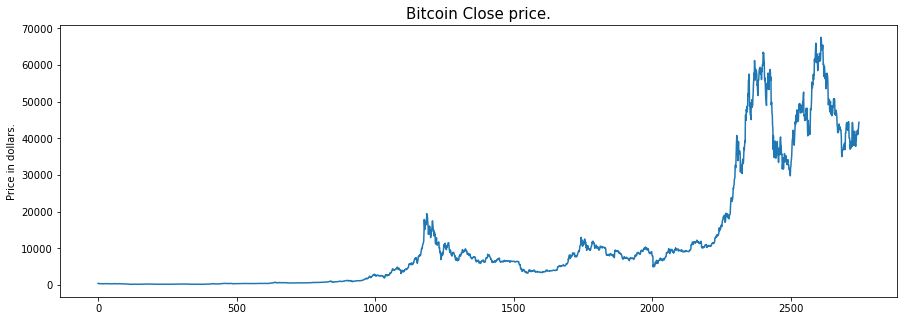

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price.', fontsize = 15)
plt.ylabel('Price in dollars.')
plt.show()

In [19]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((2747, 7), (2747, 7))

In [21]:
df = df.drop(['Adj Close'], axis = 1)

In [22]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

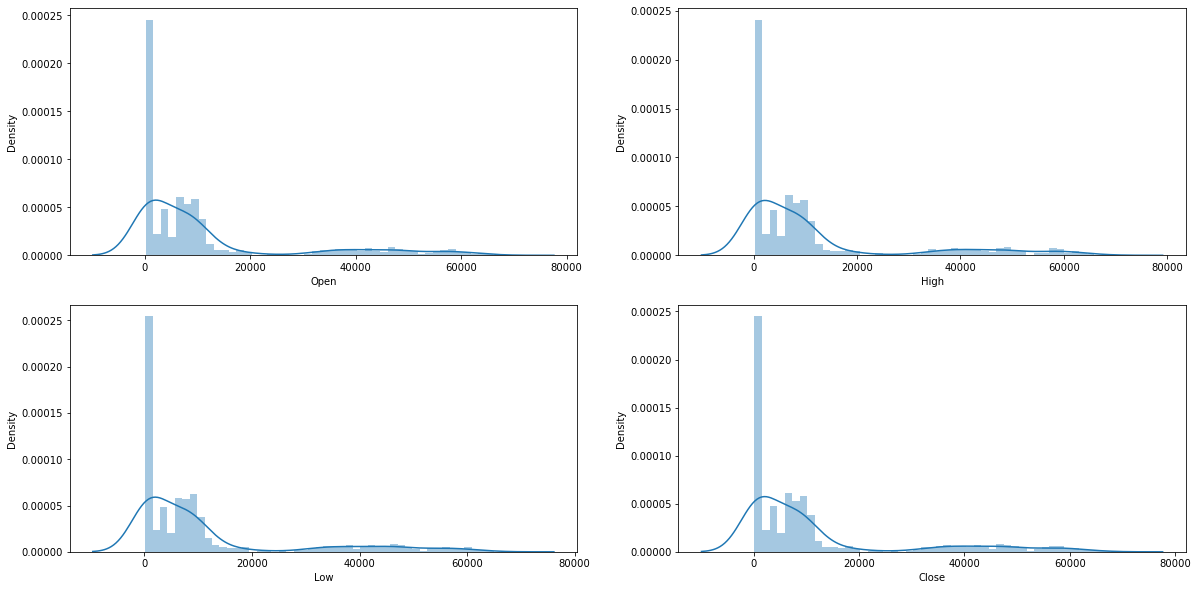

In [24]:
features = ['Open', 'High', 'Low', 'Close']
plt.subplots(figsize = (20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sb.distplot(df[col])
plt.show()    
    
    

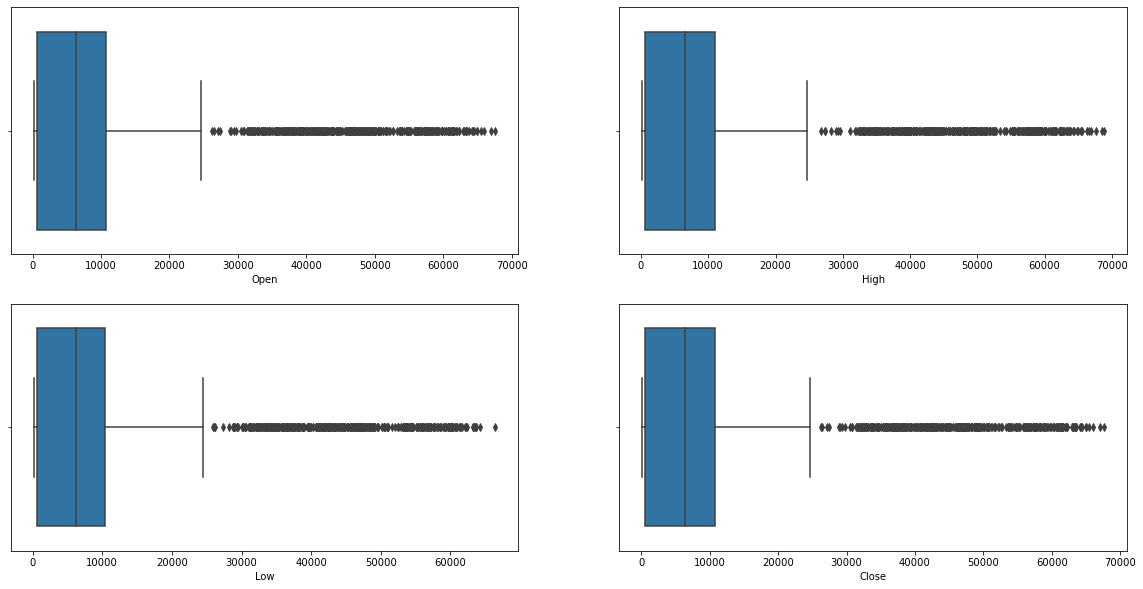

In [25]:
plt.subplots(figsize = (20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sb.boxplot(df[col])
plt.show()    

In [27]:
splitter = df['Date'].str.split('-', expand = True)

df['year'] = splitter[0].astype('int')
df['month'] = splitter[1].astype('int')
df['day'] = splitter[2].astype('int')

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


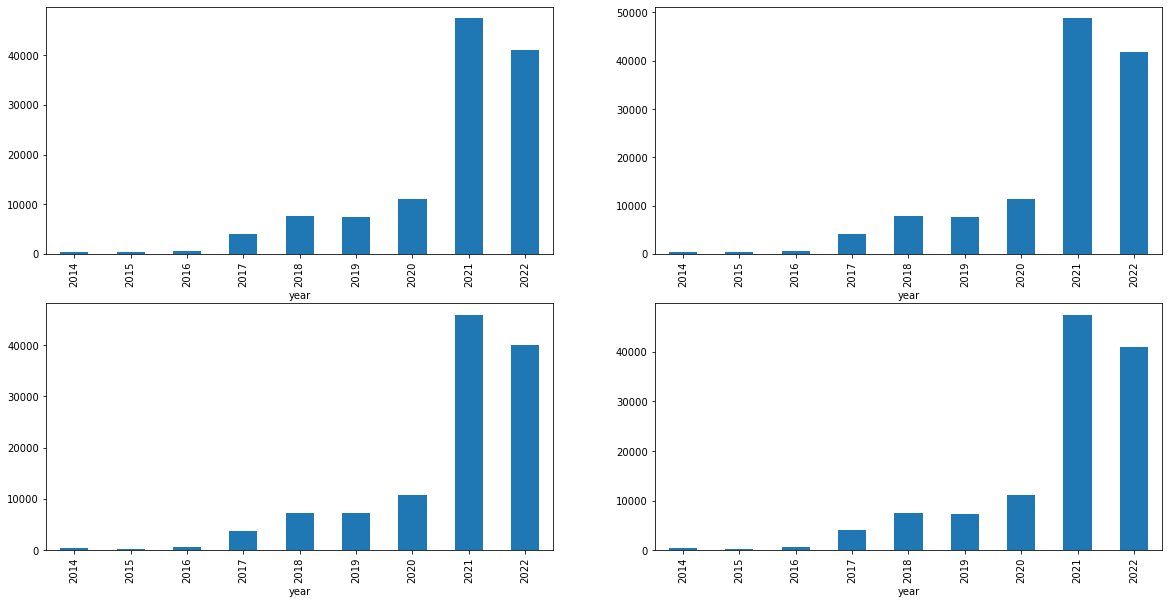

In [28]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize = (20, 10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i+1)
    data_grouped[col].plot.bar()
plt.show()    

In [29]:
df['is_quarter_end'] = np.where(df['month'] % 3 == 0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [31]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

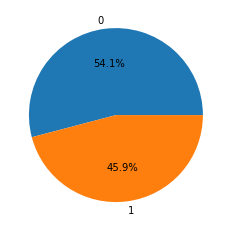

In [32]:
plt.pie(df['target'].value_counts().values, labels = [0, 1], autopct = '%1.1f%%')
plt.show()

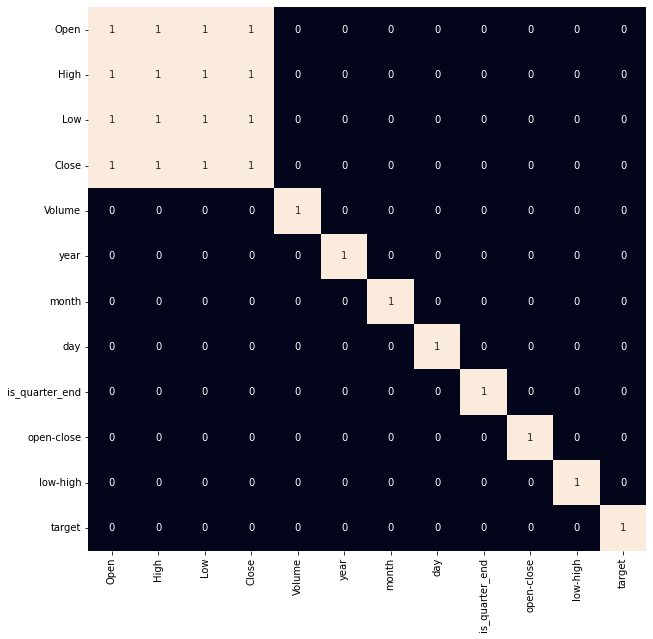

In [33]:
plt.figure(figsize = (10, 10))

# As our concern is with the highly correlated features only so,
# we will visualize our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot = True, cbar = False)
plt.show()

In [34]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size = 0.1, random_state = 2022)
print(X_train.shape, X_valid.shape)



(2472, 3) (275, 3)


In [35]:
models = [LogisticRegression(), SVC(kernel = 'poly', probability = True), XGBClassifier()]
for i in range(3):
    models[i].fit(X_train, Y_train)
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:, 1]))
    print()

LogisticRegression() : 
Training Accuracy :  0.5296927604442233
Validation Accuracy :  0.5166847826086955

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4683225015069795
Validation Accuracy :  0.5219565217391304

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accura

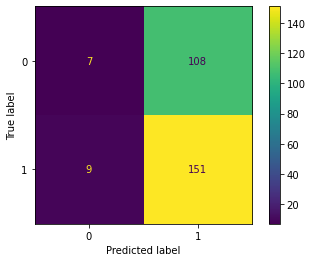

In [36]:
metrics.plot_confusion_matrix(models[0], X_valid, Y_valid)
plt.show()